# How to Derive Syntactic Structure from Text

Check out: https://demos.explosion.ai/displacy

In [17]:
# install the spaCy library
# !pip install spacy

# download the small English model (web model)
# this gives us a pretrained pipeline we can use for tagging, NER, parsing, etc.
# !python3 -m spacy download en_core_web_sm

In [18]:
import spacy
import pandas as pd

nlp = spacy.load("en_core_web_sm")

In [19]:
%%time
reddit_sample_he_she = pd.read_csv("https://raw.githubusercontent.com/EmoryHPC/DSCI-340/main/reddit_sample.csv")
reddit_sample_he_she.head()

reddit_sample_he_she_text = reddit_sample_he_she['body'].copy()
reddit_sample_he_she_text = list(nlp.pipe(reddit_sample_he_she_text, disable = ["ent"]))

CPU times: user 25.8 s, sys: 209 ms, total: 26.1 s
Wall time: 26.9 s


In [ ]:
reddit_sample_he_she_text

### Extracting Parts-of-Speech from Parsed Reddit Text

Now we can begin extracting grammatical parts-of-speech for the purpose of looking for language trends. The following code extracts grammatical pairs where the subject is tagged as a noun subject or passive noun subject, and is also a "child" of a verb.

The verb is lemmatized to prevent counting inflectional verbs separately from their base form.

In [20]:
from spacy.symbols import nsubj, nsubjpass, VERB

def extractPairs(spacy_doc_object):
    pairs = []
    for doc in spacy_doc_object:
        for subject in doc:
            if subject.dep == nsubj or subject.dep == nsubjpass and subject.head.pos == VERB:
                extracted_pairs = subject.text, subject.head.lemma_
                concat_extracted_pairs = ' '.join(extracted_pairs)
                pairs.append(str(concat_extracted_pairs))
    return pairs

pairs = extractPairs(reddit_sample_he_she_text)

In [21]:
pairs[:30]

['he go',
 'options be',
 'that have',
 'He buy',
 'legislature cook',
 'that affect',
 'It ’',
 'he be',
 'it ’s',
 'It ’',
 'he be',
 'it be',
 'it be',
 'He have',
 'crimes allow',
 'He can',
 'he do',
 'shoulders be',
 'I wonder',
 'insurgents do',
 'Jan. succeed',
 'I ’m',
 'trump turn',
 '’ve turn',
 'he see',
 'they be',
 'they do',
 'rioters think',
 'they get',
 'trump be']

`pairs` is a list subjects followed by verbs. For the sake of counting and matching with words regardless of case, we can transform all words to lower case.

In [22]:
lowercase_pairs = [word.lower() for word in pairs]

In [23]:
lowercase_pairs[:30]

['he go',
 'options be',
 'that have',
 'he buy',
 'legislature cook',
 'that affect',
 'it ’',
 'he be',
 'it ’s',
 'it ’',
 'he be',
 'it be',
 'it be',
 'he have',
 'crimes allow',
 'he can',
 'he do',
 'shoulders be',
 'i wonder',
 'insurgents do',
 'jan. succeed',
 'i ’m',
 'trump turn',
 '’ve turn',
 'he see',
 'they be',
 'they do',
 'rioters think',
 'they get',
 'trump be']

We can narrow these results to just pairs containing gendered pronouns for the purpose of exploring our guiding question: what kinds of actions are associated with masculine and femanine pronouns?

### Filtering for Gendered Pronoun-Verb Pairs

The goal of this Notebook is to extract gendered pronoun-verb pairs and create visualizations that compare male pronoun-verb pairs and female pronoun-verb pairs. First, however, we will just extract pairs with the pronoun he.

We can search for "he" and its grammatical verbs by treating "he" as a regular expression (or sequence of characters that define a search pattern). The following code defines our regular expression, `('he ')`, and creates a variable for each pair that contains a match.

In [24]:
import re

def extractMalePairs(pairs):
    regex = re.compile('he ')
    male = [word for word in lowercase_pairs if regex.match(word)]
    return male

male = extractMalePairs(lowercase_pairs)

In [25]:
male[:30]

['he go',
 'he buy',
 'he be',
 'he be',
 'he have',
 'he can',
 'he do',
 'he see',
 'he be',
 'he downplay',
 'he encourage',
 'he do',
 'he pay',
 'he be',
 'he do',
 'he ’',
 'he know',
 'he be',
 'he be',
 'he express',
 'he say',
 'he say',
 'he be',
 'he recognize',
 'he make',
 'he be',
 'he do',
 'he be',
 'he be',
 'he cock']

Viewing just the first 30 lines of our lists shows us that our gendered pronoun-verb pairs contain stop words like be or say. Pairs containing a stop word can be removed.

We can do this by first defining our stop words . . .

In [26]:
stopwords = ['right', 'hon', 'general', 'mr', 'shall', 'majesty', 'exchequer', 'address', 'motion', 'bill',
             'earl', 'friend', 'chancellor', 'sense', 'object', 'suppose', 'amidst', 'noble', 'lord', 'agree',
             'speech', 'kind', 'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september',
             'october', 'november', 'december', 'order', 'held', 'hold', 'assembly', '£', 'humble', 'about', 'above',
             'across', 'address', 'after', 'afterwards', 'again', 'against', 'agree', 'all', 'almost', 'alone', 'along',
             'already', 'also', 'although', 'always', 'am', 'amidst', 'among', 'amongst', 'amount', 'an', 'and', 'another',
             'any', 'anyhow', 'anything', 'anyway', 'anywhere', 'april', 'are', 'around', 'as', 'at', 'back', 'be', 'was',
             'becames', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being',
             'beside', 'besides', 'between', 'beyond', 'both', 'bottom', 'but', 'by', 'call', 'can', 'cannot', 'do',
             'could', 'did', 'does', 'doing', 'done', 'down', 'due', 'during', 'each', 'either', 'else', 'elsewhere',
             'empty', 'enough', 'even', 'ever', 'everyone', 'everything', 'everywhere', 'except', 'few', 'first', 'for',
             'from', 'front', 'full', 'further', 'general', 'get', 'give', 'go', 'had', 'has', 'have', 'held', 'hence',
             'here', 'hereby', 'herein', 'hold', 'however', 'if', 'in', 'indeed', 'into', 'is', 'it', 'its', 'itself',
             'just', 'keep', 'kind', 'last', 'latter', 'least', 'less', 'made', 'make', 'many', 'me', 'meanwhile', 'might',
             'mine', 'more', 'most', 'mostly', 'move', 'much', 'must', 'name,' 'neither', 'never', 'nevertheless', 'next',
             'no', 'noble', 'nobody', 'none', 'nor', 'nothing', 'now', 'nowhere', 'of', 'off', 'often', 'on', 'one', 'once',
             'only', 'onto', 'or', 'other', 'others', 'otherwise', 'out', 'over', 'own', 'part', 'perhaps', 'please', 'put',
             'quite', 'rather', 'really', 'regarding', 'same', 'say', 'see', 'seem', 'seemed', 'seeming', 'seems', 'sense',
             'several', 'shall', 'should', 'show', 'side', 'since', 'so', 'some', 'someone', 'something', 'sometime',
             'still', 'such', 'suppose', 'take', 'than', 'that', 'the', 'then', 'there', 'thereby', 'therefore', 'these',
             'they', 'this', 'those', 'though', 'thus', 'to', 'together', 'too', 'top', 'toward', 'towards', 'under',
             'unless', 'until', 'up', 'upon', 'us', 'used', 'using', 'various', 'very', 'was', 'we', 'well', 'were', 'what',
             'whatever', 'when', 'when', 'whereby', 'whether', 'which', 'while', 'who', 'why', 'will', 'with', 'within',
             'without', 'would', 'yet', 'bright', 'mr.', 'hansard', 'lancashire', '[]', '£1', '000', 'russell', 'committee',
             'reading', 'learned', 'deal', 'time', 'royal', 'gentlemen', 'gentleman', 'year', 'years', 'affairs', 'affair',
             'academy', 'sir', 'thought', 'took', 'bring', 'brings', 'brought', 'forward', 'great', 'good', 'department',
             'treasury', 'second', 'take', 'taken', 'privy', 'member', 'robert', 'large', 'session', 'secretary', 'notice',
             'moment', 'think', 'believe', 'hope', 'ask', 'hear', 'beg', 'support', 'state', 'find', 'admit', 'wish',
             'refer', 'reply', 'know', 'feel', 'propose', 'understand', 'let', 'allow', 'like', 'receive', 'consider',
             'begin', 'tell', 'like', 'send', 'ought', 'come', 'intend', 'add', 'want', 'stand', 'suggest', 'remind',
             'use', 'mean', 'suggest', 's', '’', '’s']

. . . and then matching this list with our pairs to see whether any tokens match a stop word.

The following code removes stop words by a) splitting the pair into individual tokens, b) creating a variable, `tokens_filtered` for just words that do not match a stop word, and c) joining indiviudal words back together to make a pair.

In [27]:
tokens_joined = []

for pair in male:
    tokens = pair.split(" ")
    tokens_filtered = [word for word in tokens if not word in stopwords]
    tokens = " ".join(tokens_filtered)
    tokens_joined.append(str(tokens))

In [28]:
tokens_joined[:25]

['he',
 'he buy',
 'he',
 'he',
 'he',
 'he',
 'he',
 'he',
 'he',
 'he downplay',
 'he encourage',
 'he',
 'he pay',
 'he',
 'he',
 'he',
 'he',
 'he',
 'he',
 'he express',
 'he',
 'he',
 'he',
 'he recognize',
 'he']

We have a problem, however. After joining the individual words we are left with messy data: some strings only have one word because the other word was removed.

We can remove these individual tokens by writing a line of logic that only keeps strings that are the length of two (i.e. strings that are pairs).

In [29]:
def removeStopWords(pairs):
    keep_pairs = []
    for pair in pairs:
        tokens = pair.split(" ")
        tokens_filtered = [word for word in tokens if not word in stopwords]
        joined_tokens = " ".join(tokens_filtered)
        if len(tokens_filtered) == 2: # if string is length of two
            keep_pairs.append(str(joined_tokens)) # keep the string
    return keep_pairs

male_no_stopwords = removeStopWords(male)

In [30]:
male_no_stopwords[:30]

['he buy',
 'he downplay',
 'he encourage',
 'he pay',
 'he express',
 'he recognize',
 'he cock',
 'he walk',
 'he turn',
 'he kill',
 'he execute',
 'he employ',
 'he employ',
 'he fly',
 'he boast',
 'he shoot',
 'he live',
 'he minimize',
 'he face',
 'he instigate',
 'he snap',
 'he laugh',
 'he extend',
 'he arrest',
 'he deign',
 'he pass',
 'he resign',
 'he bargain',
 'he realize',
 'he pursue']

### Counting Gendered Pronoun-Verb Pairs

After aggregating gendered pronouns that syntactically depend on a verb, we can count their frequency.

The following code defines a function, `countWords()`, that creates a dictionary of every unique pair and its frequency. Any pair not already in the dictionary is added. If the pair is already part of the dictionary its count increments by 1.

In [31]:
def countWords(clean_data):
    ngrams_dict = {}
    for ngram in clean_data:
        if ngram in ngrams_dict:
            ngrams_dict[ngram] += 1
        else:
            ngrams_dict[ngram] = 1
    return ngrams_dict

male_dictionary = countWords(male_no_stopwords)

In [32]:
for kv in list(male_dictionary)[:30]:
    print(kv,  male_dictionary[kv])

he buy 9
he downplay 1
he encourage 3
he pay 30
he express 1
he recognize 3
he cock 1
he walk 4
he turn 7
he kill 17
he execute 2
he employ 2
he fly 4
he boast 2
he shoot 15
he live 9
he minimize 1
he face 11
he instigate 2
he snap 2
he laugh 2
he extend 1
he arrest 7
he deign 1
he pass 4
he resign 20
he bargain 1
he realize 5
he pursue 1
he lose 37


Dictionaries do not store data in sequential order. This is because a dictionary is "hashable," and not linear like a list. While this makes dictionaries quick to process, its organization is not conducive to analysis.

Therefore, we will cast the pronoun-verb pairs and their counts to a pandas DataFrame.

In [33]:
male_pronoun_verb_counts = pd.DataFrame(male_dictionary.items(),columns = ['Pair','Count'])

After creating a pandas DataFrame with our pronoun-verb pairs we can arrange the frequency counts so pairs with the highest count are first.

In [34]:
male_pronoun_verb_counts.sort_values(by=['Count'], inplace=True, ascending=False)

In [35]:
male_pronoun_verb_counts

,Pair,Count
38,he win,46
35,he try,40
29,he lose,37
63,he look,31
3,he pay,30
...,...,...
511,he pen,1
510,he wander,1
509,he paralyze,1
508,he dare,1


In [36]:
# Instead of running spaCy on all the data again, I could save my processed dataset to my computer
# male_pronoun_verb_counts.to_csv('male_pronoun_verb_counts.csv') # save your variable to a CSV file on disk
# loaded_male_pronoun_verb_counts = pd.read_csv('male_pronoun_verb_counts.csv') # load your CSV file

### Visualizing our Results for Analysis

We are now ready to visualize our results: grammatical pronoun-verb pairs that show us which verbs are commonly associated with the pronoun he in our Reddit sample of "Worldnews," "News," and "Politics."

The following code takes a subset of the first 25 rows of `male_pronoun_verb_counts`.

In [37]:
top_male_pronoun_verb_counts = male_pronoun_verb_counts[:25].copy()

In [38]:
top_male_pronoun_verb_counts

,Pair,Count
38,he win,46
35,he try,40
29,he lose,37
63,he look,31
3,he pay,30
30,he lie,29
94,he run,26
54,he vote,23
25,he resign,20
96,he need,18


These top grammatical pairs can now be visualized with matplotlib.

The following code imports matplotlib, sets the plot's size, and renders the visualization.

In [39]:
import matplotlib as plt

plt.rcParams['figure.figsize'] = [15, 10]

top_male_pronoun_verb_counts.sort_values(by=['Count'], inplace=True, ascending=True)

<Axes: title={'center': 'Top Grammatical Pronoun-Verb Pairs with He: Searching the Worldnews, Politics, and News Subreddits'}, ylabel='Pair'>

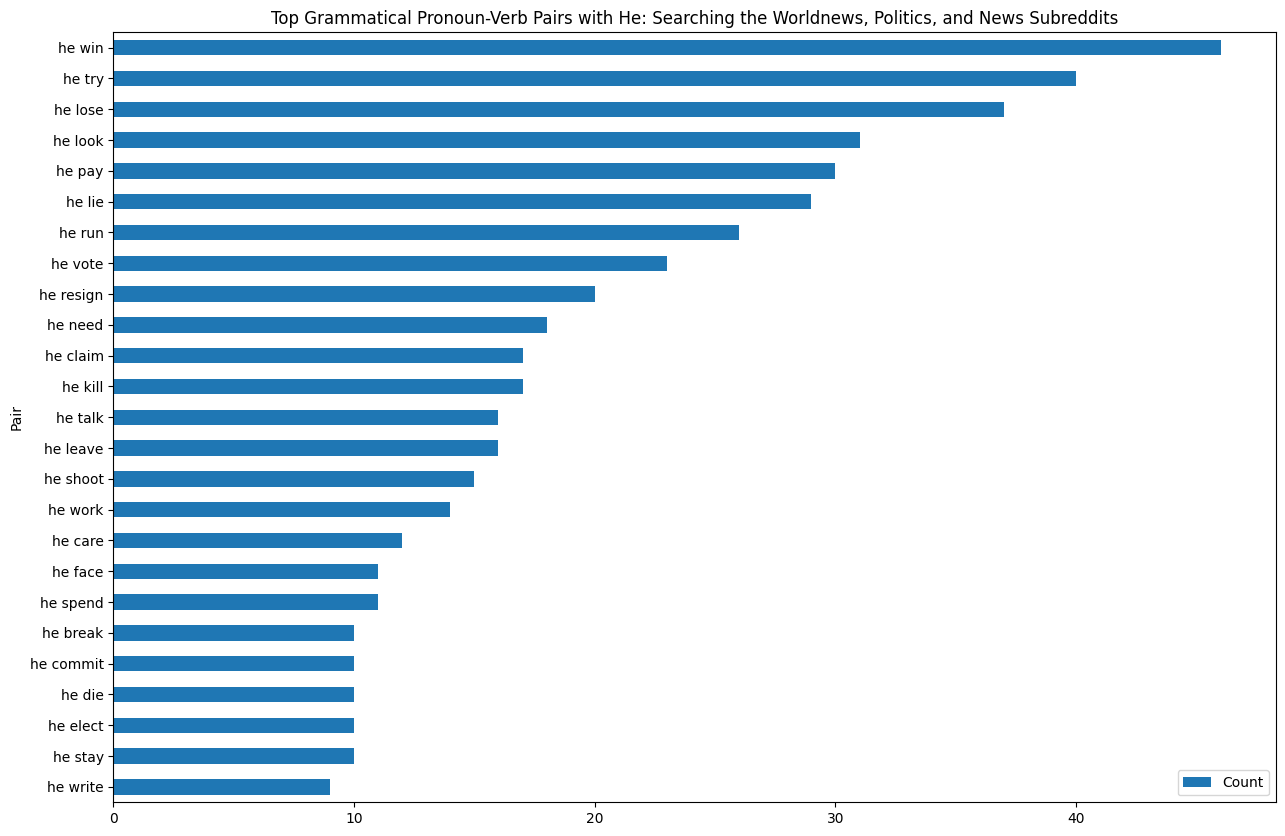

In [40]:
top_male_pronoun_verb_counts.plot.barh(x = "Pair", y = "Count",
            title = "Top Grammatical Pronoun-Verb Pairs with He: Searching the Worldnews, Politics, and News Subreddits")

> Note: This corpus has been edited. I censored the data and removed a common vulgar word.

### Reiterating the Process to Extract Female Grammatical Pronouns and their Verbs

We can reiterate the same process outlined above to extract the pronoun she and its grammatical verbs. The following code defines one new function (to extract female pronoun-verb pairs) and then calls our already defined functions to render a bar graph of top pairs.

<Axes: title={'center': 'Top Grammatical Pronoun-Verb Pairs with She: Searching the Worldnews, Politics, and News Subreddits'}, ylabel='Pair'>

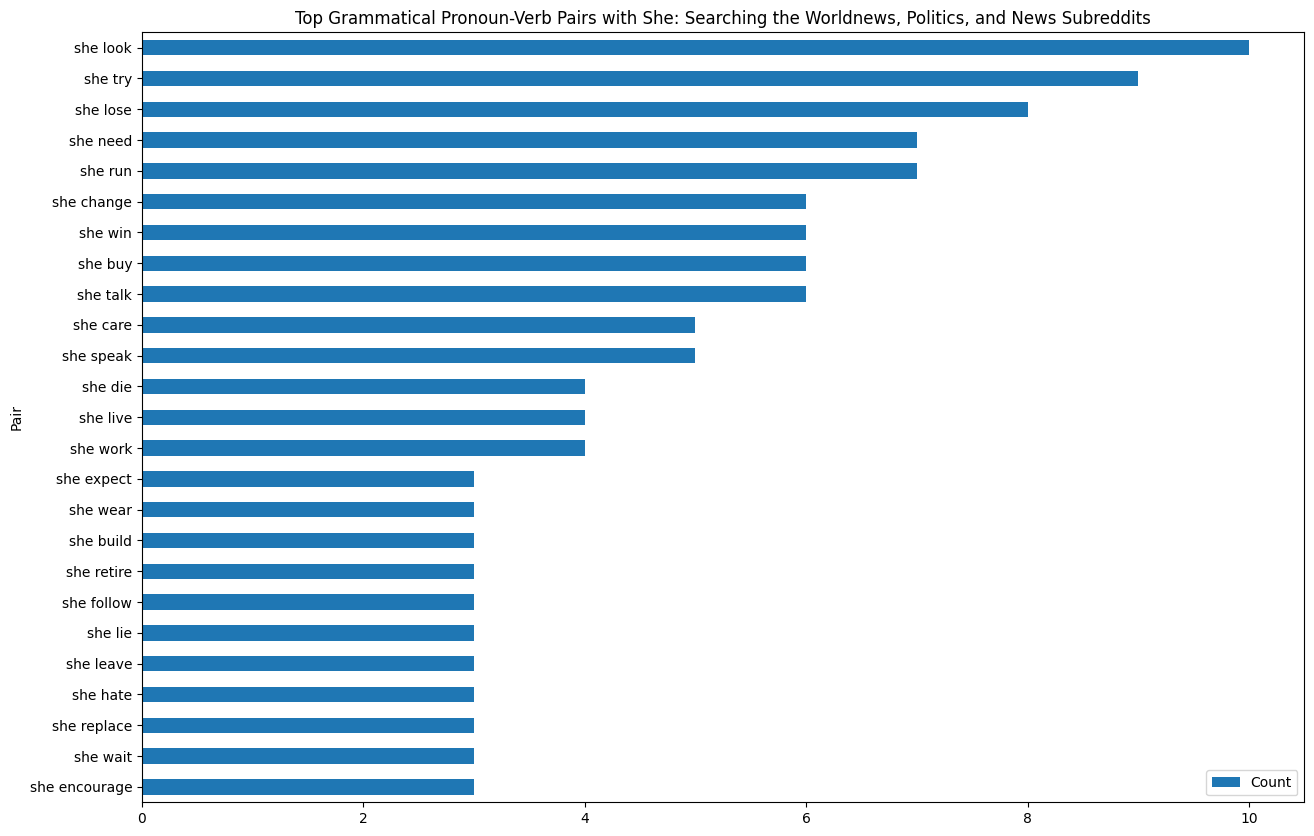

In [41]:
# extract grammatical pronoun-verb pairs where she is subject
def extractFemalePairs(pairs):
    regex = re.compile('she ')
    female = [word for word in lowercase_pairs if regex.match(word)]
    return female

female = extractFemalePairs(lowercase_pairs)

# remove stop words
female_no_stopwords = removeStopWords(female)

# create a dictionary with each unique pair and its frequency
female_dictionary = countWords(female_no_stopwords)

# create a data frame from our dictionary of grammatical pairs
female_pronoun_verb_counts = pd.DataFrame(female_dictionary.items(),columns = ['Pair','Count'])

# arrange in ascending order
female_pronoun_verb_counts.sort_values(by=['Count'], inplace=True, ascending=False)

# take a subset of the data
top_female_pronoun_verb_counts = female_pronoun_verb_counts[:25].copy()

# set the parameters of the visualization
plt.rcParams['figure.figsize'] = [15, 10]

# sort the pairs for visualization
top_female_pronoun_verb_counts.sort_values(by=['Count'], inplace=True, ascending=True)

# render visualization
top_female_pronoun_verb_counts.plot.barh(x = "Pair", y = "Count",
            title = "Top Grammatical Pronoun-Verb Pairs with She: Searching the Worldnews, Politics, and News Subreddits")

### Extracting Adjectives that Modify the Words "Man" and "Woman"


To keep our data sets small, you can read in another subset of the Reddit data which includes just sentences with the word "man" or "woman."

In [42]:
reddit_man_woman_corpus = pd.read_csv("reddit_sample.csv")

reddit_man_woman_corpus_text = reddit_man_woman_corpus['body'].copy()

reddit_man_woman_corpus_text = list(nlp.pipe(reddit_man_woman_corpus_text, disable = ["ent"]))

FileNotFoundError: [Errno 2] No such file or directory: 'reddit_sample.csv'

As mentioned, you can modiy the code in this Notebook to extract female adjective-noun pairs. To see what I mean, let's get started on this problem together.

We know we already have functions that count pairs, create DataFrames, and visualize our results. Therefore, we just need to change the code that determines which pairs are extracted. Instead of extracting noun-verb pairs we want to extract adjective-noun pairs.

So, let's return to the `extractPairs()` function and modify it for our assignment. Instead of using the symbols `nsubj` (for noun subject), `nsubjpass` (for passive noun subject) and `VERB`, we will use `amod` (for adjectival modifier), `acomp` (for adjectival complement), and `NOUN`.

In [ ]:
from spacy.symbols import amod, acomp, NOUN

def extractAdjNounPairs(spacy_doc_object):
    pairs = []
    for doc in spacy_doc_object:
        for adjective in doc:
            if adjective.dep == amod or adjective.dep == acomp and adjective.head.pos == NOUN: # or adjective.dep == ccomp or adjective.dep == conj
                extracted_pairs = adjective.text, adjective.head.lemma_
                concat_extracted_pairs = ' '.join(extracted_pairs)
                pairs.append(str(concat_extracted_pairs))
    return pairs

adjective_noun_pairs = extractAdjNounPairs(reddit_man_woman_corpus_text)

In [ ]:
adjective_noun_pairs[:30]

Like our previous code, we can transform each pair to lower case so the same word with a different case is not counted separately. In other words, we don't want to count "Woman" and "woman" separately.

In [ ]:
lowercase_adjective_noun_pairs = [word.lower() for word in adjective_noun_pairs]

Now instead of extracting pairs with the regular expression "she " we can extract pairs with the regular expression " woman."

In [ ]:
def extractFemaleAdjNounPairs(lowercase_adjective_noun_pairs):
    regex = re.compile(' woman')
    female = [word for word in lowercase_adjective_noun_pairs if regex.search(word)]
    return female

female_adj_noun_pairs = extractFemaleAdjNounPairs(lowercase_adjective_noun_pairs)

In [ ]:
female_adj_noun_pairs[:30]

We can now use our functions to count and visualize our data.

In [ ]:
# remove stop words
female_adj_noun_pairs_no_stopwords = removeStopWords(female_adj_noun_pairs)

# create a dictionary with each unique pair and its frequency
female_adj_noun_dictionary = countWords(female_adj_noun_pairs_no_stopwords)

# create a data frame from our dictionary of grammatical pairs
female_adj_noun_df = pd.DataFrame(female_adj_noun_dictionary.items(),columns = ['Pair','Count'])

# arrange in ascending order
female_adj_noun_df.sort_values(by=['Count'], inplace=True, ascending=False)

top_female_adj_noun_counts = female_adj_noun_df[:45].copy()

# set the parameters of the visualization
plt.rcParams['figure.figsize'] = [15, 10]

# sort the pairs for visualization
top_female_adj_noun_counts.sort_values(by=['Count'], inplace=True, ascending=True)

# render visualization
top_female_adj_noun_counts.plot.barh(x = "Pair", y = "Count",
            title = "Top Grammatical Adjective-Noun Pairs with Woman: Searching the Worldnews, Politics, and News Subreddits")

In [ ]:
def extractMaleAdjNounPairs(lowercase_adjective_noun_pairs):
    regex = re.compile('\\bman\\b')
    man = [word for word in lowercase_adjective_noun_pairs if regex.search(word)]
    return man

male_adj_noun_pairs = extractMaleAdjNounPairs(lowercase_adjective_noun_pairs)

In [ ]:
# remove stop words
male_adj_noun_pairs_no_stopwords = removeStopWords(male_adj_noun_pairs)

# create a dictionary with each unique pair and its frequency
male_adj_noun_dictionary = countWords(male_adj_noun_pairs_no_stopwords)

# create a data frame from our dictionary of grammatical pairs
male_adj_noun_df = pd.DataFrame(male_adj_noun_dictionary.items(), columns=['Pair', 'Count'])

# arrange in ascending order
male_adj_noun_df.sort_values(by=['Count'], inplace=True, ascending=False)

top_male_adj_noun_counts = male_adj_noun_df[:45].copy()

# set the parameters of the visualization
plt.rcParams['figure.figsize'] = [15, 10]

# sort the pairs for visualization
top_male_adj_noun_counts.sort_values(by=['Count'], inplace=True, ascending=True)

# render visualization
top_male_adj_noun_counts.plot.barh(
    x="Pair",
    y="Count",
    title="Top Grammatical Adjective-Noun Pairs with Man: Searching the Worldnews, Politics, and News Subreddits")
